In [94]:
from random import random
import pandas
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [95]:
chiavi=["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal"]


#carico file per il dataset
heart=pandas.read_csv(r"/home/matteo/heart.csv")

#inizializzazione x
x=heart.drop("target",axis=1)

#inizializzazione y con valore target
y=heart[:]["target"].values

#split in train e test di x e y in 80/20
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

Heatmap, mi mostra la correlazione tra le features, non so come non so perchè mami mostra qualcosa:

<AxesSubplot:>

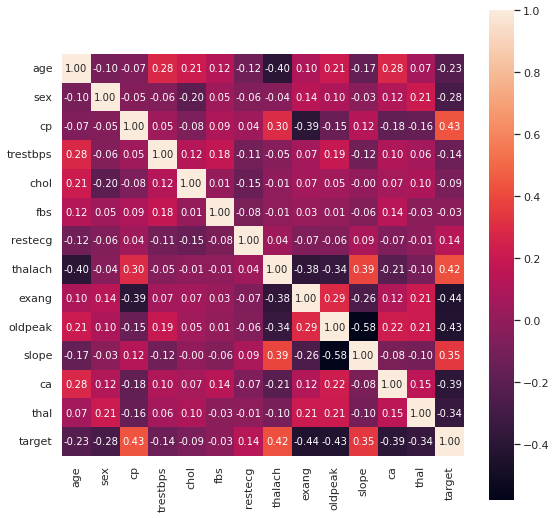

In [114]:
import seaborn as sns
sns.set (rc = {'figure.figsize':(9, 9)})
sns.heatmap(heart.corr(), 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=heart.columns, 
                 xticklabels=heart.columns, )

Heatmap segna una features, per ogni features, l'idea era di fare un po di features selection, ma ad occhio non rendono molta differenza, non ho trovato nulla per fare una differenza tra le heatmap (la cosa più veloce sta sotto):

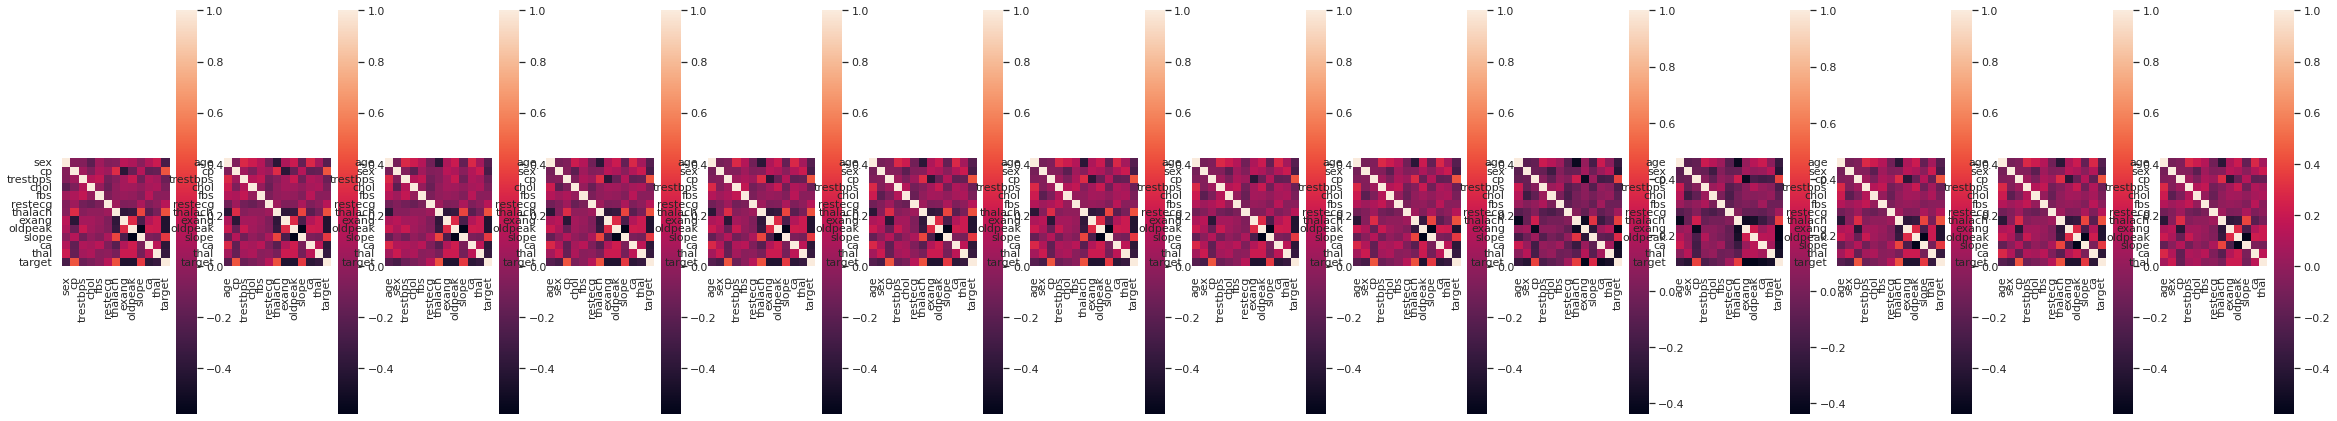

In [98]:
fig = plt.figure(figsize = (40,40)) # width x height
allheatmap = []
index=1
for i in heart:
    ax1 = fig.add_subplot(1, 14, index) # row, column, position
    h = heart.drop(columns=[i])
    sns.set (rc = {'figure.figsize':(6, 6)})
    hm = sns.heatmap(h.corr(), 
                    cbar=True, 
                    #annot=True, 
                    square=True, 
                    fmt='.2f', 
                    annot_kws={'size': 10}, 
                    yticklabels=h.columns, 
                    xticklabels=h.columns, ax = ax1)

    index+=1
plt.show()

!! Non riesco a far diminuire la loss function anche se lievemnte migliora l'accuracy
prima sempre accuracy sotto il 50% con altro loss function
sparse_categorical_crossentropy sembra la più promettente
per il momento dropout non sta aiutando, e non ha aiutato neanche complicare l'architettura
so passato da un test set del 20% al 25% ed ho ottenuto miglioramenti
peggioramenti per quanto riguarda il 30% di test set
per ilmomento nessun miglioramento anchealterando numero di epoche (da 1 a 1000) e batchsize (mosso da 1 a 300)

CONFIGURAZIONE MIGLIORE ATTUALMENTE:
model.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.fit(x_train,y_train,batch_size=10,epochs=100)
3/3 [==============================] - 0s 2ms/step - loss: 0.6859 - accuracy: 0.5658

rimossi tutti i drop outp (0.7), rimossi 2 layer uno da 512 e uno da 256
BEAST:
model.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.fit(x_train,y_train,batch_size=10,epochs=100)
3/3 [==============================] - 0s 2ms/step - loss: 0.4288 - accuracy: 0.8289

provato ulteriormente a semplificare ma solo peggioramenti
lo stesso vale per i dropout a 0.7
provato da relu a gelu dai layer piu esterni a più interni ma senza benefit 
anzi un live benefit con tute gelu dello 0.02
stessa pratica con tanh ma lieve peggioramento
Nel caso precedente il mio input layer era di 128, più volte prendeva in inuput una riga(?)
ora con un input layer da 13 accuracy diminuita
ho recuperando impostando sull'input layer la relu e passando dai 128 ai 96 nodi del 1 layer

BEST:
23/23 [==============================] - 0s 3ms/step - loss: 0.4474 - accuracy: 0.8018
3/3 [==============================] - 0s 3ms/step - loss: 0.4269 - accuracy: 0.8421
rimossa relu su input layer, tutte gelu.

BEST:
3/3 [==============================] - 0s 6ms/step - loss: 0.3963 - accuracy: 0.8816
[0.39634600281715393, 0.8815789222717285]
aumentando le epoche a 150 e facendo vari run 

anche l'ultima funzione di attivazione nell'input layer è gelu, non da score migliori dell'88% però è molto stabile durante i vari training sull'86/87%, rispetto l'altra che ho trovato una configurazione buona tra molti run.

In [117]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(13,tf.keras.activations.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    #tf.keras.layers.Dense(100,tf.keras.activations.gelu),
    tf.keras.layers.Dense(96,tf.keras.activations.gelu),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64,tf.keras.activations.gelu),
    
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,tf.keras.activations.gelu),
    #tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(16,tf.keras.activations.gelu),
    #tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(8,tf.keras.activations.gelu),
    #tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(4,tf.keras.activations.gelu),
    #tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(2,tf.keras.activations.softmax)
])

model.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.fit(x_train,y_train,batch_size=10,epochs=150,)
model.evaluate(x_test,y_test)

Epoch 1/150
23/23 [==============================] - 3s 3ms/step - loss: 0.6484 - accuracy: 0.6476
Epoch 2/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5769 - accuracy: 0.7048
Epoch 3/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5549 - accuracy: 0.7665
Epoch 4/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5080 - accuracy: 0.7797
Epoch 5/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4733 - accuracy: 0.7709
Epoch 6/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5232 - accuracy: 0.7665
Epoch 7/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4964 - accuracy: 0.7753
Epoch 8/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4558 - accuracy: 0.8062
Epoch 9/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4506 - accuracy: 0.8106
Epoch 10/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4525 - accuracy: 0.7841
Epoch 11/

[0.3894613981246948, 0.8684210777282715]

Features selection a mano, l'unica pecca è lo split sarebbe ottimo farlo una volta soltanto e non rifarlo ogni volta
ora ho impostato il seed ed in teoria dovrebbe farmi sempre lo stesso split (il problema che scambio delle colonne quindi non ne sono particolarmente sicuro che sia sempre lo stesso):

In [100]:
best_score = ['',0]
all_score = {}

for i in chiavi:
    model_1 = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(12,tf.keras.activations.relu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        #tf.keras.layers.Dense(100,tf.keras.activations.gelu),
        tf.keras.layers.Dense(96,tf.keras.activations.gelu),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64,tf.keras.activations.gelu),
        
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32,tf.keras.activations.gelu),
        #tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(16,tf.keras.activations.gelu),
        #tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(8,tf.keras.activations.gelu),
        #tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(4,tf.keras.activations.gelu),
        #tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(2,tf.keras.activations.softmax)
    ])
    model_1.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

    print('--------------------------------------- FEATURES USATE -------------------------------------------')
    position = chiavi.index(i)
    print(chiavi[:position],chiavi[position+1:])
    print('--------------------------------------------------------------------------------------------------')
    
    # rimuovo features di prova
    h = heart.drop(columns=[i])
    # rimuovo target
    x_mod=h.drop("target",axis=1)
    # tengo il target
    y_mod=h[:]["target"].values
    # splitto con seed fissato ottengo sempre lo stesso splitt (in teoria)
    x_train_mod,x_test_mod,y_train_mod,y_test_mod=train_test_split(x_mod,y_mod,test_size=0.25,random_state=1)

    model_1.fit(x_train_mod,y_train_mod,batch_size=10,epochs=150)
    obj = model_1.evaluate(x_test_mod,y_test_mod)

    # salvo la migliore combo di features
    if obj[1]>best_score[1]:
        best_score = [(chiavi[:position],chiavi[position+1:]) , obj[1]]
        # carico i miglio pesi mai ottenuti li valido sullo stesso split ma con anche l'altra features
        """ model_best = tf.keras.models.load_model('/home/matteo/python/best.h5')
        obj_best = model_best.evaluate(x_test_mod,y_test_mod)
        if obj[1]>obj_best[1]: """
        model.save('/home/matteo/python/featureSelection/bestFS.h5')
        
    # salvo risultati dei vari dataset facendo features selection
    all_score[str(chiavi[:position]+chiavi[position+1:])]= obj[1]
print(best_score)


--------------------------------------- FEATURES USATE -------------------------------------------
[] ['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
--------------------------------------------------------------------------------------------------
Epoch 1/150
23/23 [==============================] - 2s 3ms/step - loss: 0.6886 - accuracy: 0.5683
Epoch 2/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.7181
Epoch 3/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5065 - accuracy: 0.7753
Epoch 4/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5322 - accuracy: 0.7313
Epoch 5/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4888 - accuracy: 0.7930
Epoch 6/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5215 - accuracy: 0.7577
Epoch 7/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4734 - accuracy: 0.7930


modello salvato con queste performance
3/3 [==============================] - 0s 6ms/step - loss: 0.3963 - accuracy: 0.8816
[0.39634600281715393, 0.8815789222717285]

In [102]:
#model.save('/home/matteo/python/best2.h5')

Best model ever con configurazione ottima lo testo e confronto:

In [103]:
model_best = tf.keras.models.load_model('/home/matteo/python/best.h5')
model_best.evaluate(x_test,y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.3272 - accuracy: 0.8816


[0.3272016644477844, 0.8815789222717285]

Un po di visualizzazione per capire il modello / i modelli:

3/3 [==============================] - 0s 1ms/step


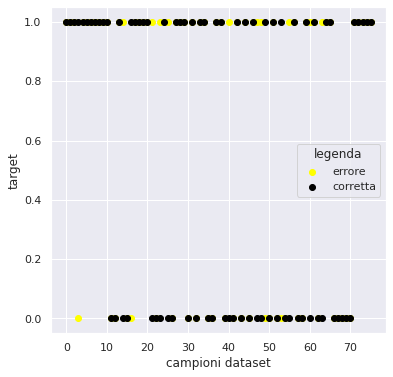

In [104]:
y_predette = model.predict(x_test)
array = []
y_pred_custom = []
j=0

for i in y_predette:
    # se [1,2] se 1 è vicino allo 0 vuol dire che devo prendere il valore 2, quanto è vicino all'_1
    # se 1 è vicino all'uno vuol dire che mi servirà 1-quel valore ovvero il valore 2
    y_pred_custom.append(i[1])
    array.append(j)
    j+=1

y_pred_arrotondate = []
for i in y_pred_custom:
    if i < 0.5:
        y_pred_arrotondate.append(0)
    else:
        y_pred_arrotondate.append(1)

# Crea il grafico con l'array di valori
plt.scatter(array,y_pred_arrotondate,c='yellow')
plt.scatter(array,y_test,c='black')
#plt.axhline(y=0.5,c='black')
plt.xlabel('campioni dataset')
plt.ylabel('target')
plt.legend(['errore','corretta'],title='legenda')
plt.show()

Proverei a fare un po di features selection
Con la pca non sto ottenendo nulla, ovvero solo peggioramenti, ma la heatmap mi dice che le nuove features identificate combinando
quelle precedenti hanno meno potere espressivo

---------Numero dimensionalita' usate 5 con una conservazione del 99.9% dell'informazione -------------



<AxesSubplot:>

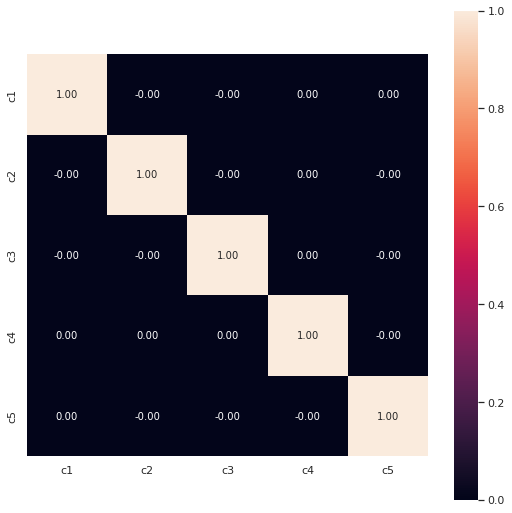

In [110]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
p=0.999
d = np.argmax(cumsum >= p) + 1

#featuresLinear.append(d)
print("---------Numero dimensionalita' usate {} con una conservazione del {}% dell'informazione -------------\n".format(d,p*100))

pca = PCA(n_components=d)
x_reduced_pca = pca.fit_transform(x_train)
x_reduced_test_pca=pca.fit_transform(x_test)
sns.set (rc = {'figure.figsize':(9, 9)})
h = pd.DataFrame(x_reduced_pca,columns=['c1','c2','c3','c4','c5'])
sns.heatmap(h.corr(), 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 vmax=1,
                 vmin=0,
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=h.columns, 
                 xticklabels=h.columns, )

In [106]:
modelPca = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5,tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    #tf.keras.layers.Dense(100,tf.keras.activations.gelu),
    tf.keras.layers.Dense(96,tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64,tf.keras.activations.gelu),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,tf.keras.activations.gelu),
    #tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(16,tf.keras.activations.gelu),
    #tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(8,tf.keras.activations.gelu),
    #tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(4,tf.keras.activations.gelu),
    #tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(2,tf.keras.activations.softmax)
])

modelPca.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
modelPca.fit(x_reduced_pca,y_train,batch_size=10,epochs=150)
modelPca.evaluate(x_reduced_test_pca,y_test)

Epoch 1/150
23/23 [==============================] - 2s 3ms/step - loss: 0.6725 - accuracy: 0.5419
Epoch 2/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6696
Epoch 3/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.6344
Epoch 4/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5912 - accuracy: 0.7004
Epoch 5/150
23/23 [==============================] - 0s 2ms/step - loss: 0.6131 - accuracy: 0.7048
Epoch 6/150
23/23 [==============================] - 0s 2ms/step - loss: 0.5896 - accuracy: 0.6828
Epoch 7/150
23/23 [==============================] - 0s 2ms/step - loss: 0.5775 - accuracy: 0.6476
Epoch 8/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6039 - accuracy: 0.6828
Epoch 9/150
23/23 [==============================] - 0s 2ms/step - loss: 0.5426 - accuracy: 0.7137
Epoch 10/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6004 - accuracy: 0.6696
Epoch 11/

[0.7980271577835083, 0.5657894611358643]

In [130]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
MLP = MLPClassifier(hidden_layer_sizes=(32), learning_rate_init=0.001, max_iter=150)
model = MLP.fit(x_train_mod, y_train_mod)
MLP_predict = MLP.predict(x_test_mod)
MLP_conf_matrix = confusion_matrix(y_test_mod, MLP_predict)
MLP_acc_score = accuracy_score(y_test_mod, MLP_predict)
print(MLP_conf_matrix)
print("\n")
print(classification_report(y_test_mod,MLP_predict))
print("Accuracy of Multilayer Perceptron classifier: {:.3f}".format(MLP_acc_score*100),'%\n')

[[23 12]
 [ 6 35]]


              precision    recall  f1-score   support

           0       0.79      0.66      0.72        35
           1       0.74      0.85      0.80        41

    accuracy                           0.76        76
   macro avg       0.77      0.76      0.76        76
weighted avg       0.77      0.76      0.76        76

Accuracy of Multilayer Perceptron classifier: 76.316 %



/home/matteo/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
